## X-Ray Abnormality Detection | DenseNet-169, pretrained on ImageNet

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
 * [Create a tensorflow input pipeline for the testing data](#Create-a-tensorflow-input-pipeline-for-the-testing-data)
- [Baseline Performance](#Baseline-Performance)
 * [DenseNet169-architecture,-pretrained-on-ImageNet](#DenseNet169-architecture,-pretrained-on-ImageNet)

In [1]:
import gc
import os
import pathlib
import random
import re
from glob import glob
from PIL import Image
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import image
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-03-27 14:06:50.853723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 14:06:50.880422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 14:06:50.880578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [8]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [9]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [10]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [11]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [12]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,train,XR_SHOULDER,patient00001,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,train,XR_SHOULDER,patient00001,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,train,XR_SHOULDER,patient00001,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,train,XR_SHOULDER,patient00002,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,train,XR_SHOULDER,patient00002,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [13]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [14]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [15]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [16]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,train,XR_SHOULDER,patient00001,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,train,XR_SHOULDER,patient00001,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,train,XR_SHOULDER,patient00001,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,train,XR_SHOULDER,patient00002,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,train,XR_SHOULDER,patient00002,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [17]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [19]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    color_mode="rgb",  # 3 channels
    batch_size=16,
    seed=SEED,
    shuffle=True,
    validate_filenames=False,
    subset="training",
)

Found 29447 non-validated image filenames belonging to 2 classes.


In [20]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    color_mode="rgb",  # 3 channels
    batch_size=16,
    seed=SEED,
    shuffle=True,
    validate_filenames=False,
    subset="validation",
)

Found 7361 non-validated image filenames belonging to 2 classes.


#### Create a tensorflow input pipeline for the testing data

In [21]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

In [22]:
test_image_paths["image_path"] = test_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [23]:
test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

In [24]:
test_labeled_studies["study_path"] = test_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_labeled_studies["label"] = test_labeled_studies["label"].map(str)

In [25]:
ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_testset)

shape: (3197, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,valid,XR_WRIST,patient11185,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,valid,XR_WRIST,patient11185,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
2,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,valid,XR_WRIST,patient11185,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
3,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,valid,XR_WRIST,patient11185,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
4,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,valid,XR_WRIST,patient11186,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1


In [26]:
testing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
)

In [27]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=16,
    seed=SEED,
)

Found 3197 validated image filenames belonging to 2 classes.


### Baseline Performance

In [28]:
def study_oriented_transformation(dataset: pd.DataFrame) -> Iterable:

    for study, group in dataset.groupby("study_path"):

        study_label = group["label"].values.take(0)
        study_prediction = 1 if group["prediction"].mean() > 0.5 else 0

        yield study, study_label, study_prediction

#### DenseNet169 architecture, pretrained on ImageNet

In [29]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [30]:
# the tfa.metrics.F1Score (https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score)
# requires some reshaping that is inconsistent with the other metrics we like to track
# so we will define it from scratch


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [31]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

2022-03-27 14:06:55.034790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 14:06:55.035529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 14:06:55.035760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 14:06:55.035893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [32]:
def plot_metrics(
    history: tf.keras.callbacks.History,
    metrics: list = ["loss", "cohen_kappa", "precision", "recall"],
) -> None:

    plt.rcParams["figure.figsize"] = (18, 15)

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], linewidth=1.8, label="training"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            linestyle="--",
            linewidth=1.8,
            label="validation",
        )
        plt.xlabel("epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "cohen_kappa":
            plt.ylim([-1, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

In [33]:
"""
Densenet-169 model from `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
"""
densenet = tf.keras.applications.densenet.DenseNet169(
    include_top=False,  # do not include the fully-connected layer at the top of the network
    weights="imagenet",
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    pooling="avg",  # pooling mode for feature extraction
    classes=2,
)

In [34]:
def make_densenet_model(
    base_model: tf.keras.applications.densenet.DenseNet201,
) -> tf.keras.Model:

    # freeze base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    # the base model contains batchnorm layer - we want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base model is running in inference mode here.
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [35]:
model = make_densenet_model(base_model=densenet)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


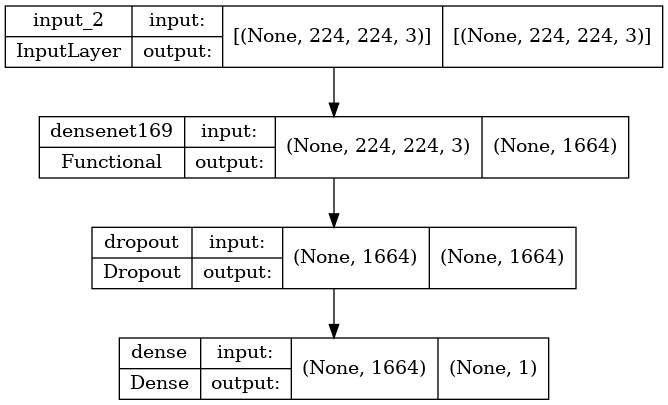

In [37]:
tf.keras.utils.plot_model(
    model,
    to_file="../static/densenet169_pt_imagenet-all-study-types-12644545.png",
    show_shapes=True,
    show_layer_names=True,
)

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
)

In [39]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa", factor=0.2, verbose=1, patience=7, min_lr=1e-10
)

In [ ]:
history = model.fit(
    trainset,
    epochs=20,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/20


2022-03-27 14:07:07.351359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-03-27 14:07:08.780399: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-03-27 14:07:10.562903: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-a

1841/1841 [==============================] - ETA: 0s - loss: 0.5869 - tp: 4470.0000 - fp: 2700.0000 - tn: 16042.0000 - fn: 6235.0000 - binary_acc: 0.6966 - precision: 0.6234 - recall: 0.4176 - f1_score: 0.5001 - roc_auc: 0.7118 - pr_auc: 0.6079 - cohen_kappa: 0.2943

In [ ]:
plot_metrics(history)

In [ ]:
# model naming convention: {architecture}-{which-study-type?}-{num-parameters}.h5
#
# to load models:
# model = tf.keras.models.load_model(
#     '../models/densenet169_pt_imagenet-all-study-types-12644545.h5',
#     custom_objects={'F1Score': F1Score}
# )
# densenet = tf.keras.models.load_model(
#     '../models/densenet169_base.h5',
# )
model.save("../models/densenet169_pt_imagenet-all-study-types-12644545.h5")
densenet.save("../models/densenet169_base.h5")

In [ ]:
# fine-tuning: unfreeze the base model and train the entire model end-to-end with a low learning rate
densenet.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

In [ ]:
history = model.fit(
    trainset,
    epochs=10,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

In [ ]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

In [ ]:
loss = evaluation_metrics.pop(0)

In [ ]:
print("EVALUATION ON TEST DATASET")
print("=" * 32)
print(f"loss        : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")
print("=" * 32)

In [ ]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

In [ ]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [ ]:
cohen_kappa_score(
    y1=temp_testset["label"].values,
    y2=np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
    labels=[0, 1],
)

In [ ]:
print(
    classification_report(
        temp_testset["label"].values,
        np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
    )
)

In [ ]:
temp_testset["prediction"] = preds.ravel()

In [ ]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [ ]:
cohen_kappa_score(
    y1=temp_testset["label"].values, y2=temp_testset["prediction"].values, labels=[0, 1]
)

In [ ]:
print(
    classification_report(
        temp_testset["label"].values,
        temp_testset["prediction"].values,
    )
)

In [ ]:
clean_up(model)
clean_up(densenet)
del temp_testset